In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
from torchvision import transforms, datasets
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import torchvision.models as models
from torch.utils.data import DataLoader

In [2]:
# Define paths to your dataset subfolders
data_root = "C:\\Users\\ai\\Desktop\\RA 2023\\CNN_classification\\wavelet\\resized_images"
class_folders = ["class1", "class2", "class3"]

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         #std=[0.5, 0.5, 0.5] )
])

# Load dataset
dataset = datasets.ImageFolder(root=data_root, transform=transform)

# Create lists to hold indices for each class
class_indices = [[], [], []]
for idx, (data, target) in enumerate(dataset):
    class_indices[target].append(idx)

# Define the sample counts per class for each set
train_samples_per_class = [80, 80, 80]
val_samples_per_class = [27, 27, 27]
test_samples_per_class = [27, 27, 27]

# Create train, validation, and test indices for each class
train_indices = [class_indices[i][:train_samples_per_class[i]] for i in range(3)]
val_indices = [class_indices[i][train_samples_per_class[i]:train_samples_per_class[i] + val_samples_per_class[i]] for i in range(3)]
test_indices = [class_indices[i][train_samples_per_class[i] + val_samples_per_class[i]:train_samples_per_class[i] + val_samples_per_class[i] + test_samples_per_class[i]] for i in range(3)]

# Flatten the indices lists
train_indices = [idx for class_idx in train_indices for idx in class_idx]
val_indices = [idx for class_idx in val_indices for idx in class_idx]
test_indices = [idx for class_idx in test_indices for idx in class_idx]

# Create datasets and data loaders for each split
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

In [3]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

240
81
81


In [4]:
BATCH_SIZE = 2
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,  num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)

In [5]:
# Calculate the number of samples from each class in each dataset
train_class_counts = [0, 0, 0]
test_class_counts = [0, 0, 0]

for idx, (data, target) in enumerate(train_dataset):
    train_class_counts[target] += 1

for idx, (data, target) in enumerate(test_dataset):
    test_class_counts[target] += 1

# Print the number of samples from each class in each dataset
print("Train class counts:", train_class_counts)
print("Test class counts:", test_class_counts)

Train class counts: [80, 80, 80]
Test class counts: [27, 27, 27]


In [6]:
vgg16 = models.vgg16(pretrained=True)

D:\python project\project2_data_visualization\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\python project\project2_data_visualization\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
for param in vgg16.features.parameters():
    param.requires_grad = False
# Extract the bottom layers
bottom_layers = vgg16.features

In [8]:
# Define the additional fully connected layers
fully_connected_layers = nn.Sequential(
    nn.Linear(512 * 7 * 7, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    
    nn.Linear(4096, 3),
)

# Combine layers to create the complete classification network
classification_network = nn.Sequential(
    bottom_layers,  
    nn.Flatten(),  # Flatten the output from the bottom layers
    fully_connected_layers,
)

In [9]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(classification_network.parameters(), lr=0.0001)

# Lists to store training and validation losses
train_losses = []
val_losses = []

# Lists to store training and validation accuracies
train_accuracies = []
val_accuracies = []

Epoch [1/5] - Train Loss: 0.4398 - Val Loss: 0.0052 - Train Acc: 89.58% - Val Acc: 100.00%
Epoch [2/5] - Train Loss: 0.0987 - Val Loss: 0.0008 - Train Acc: 97.92% - Val Acc: 100.00%
Epoch [3/5] - Train Loss: 0.1004 - Val Loss: 0.0038 - Train Acc: 99.17% - Val Acc: 100.00%
Epoch [4/5] - Train Loss: 0.0668 - Val Loss: 0.1597 - Train Acc: 99.17% - Val Acc: 96.30%
Epoch [5/5] - Train Loss: 0.0792 - Val Loss: 0.0007 - Train Acc: 98.75% - Val Acc: 100.00%


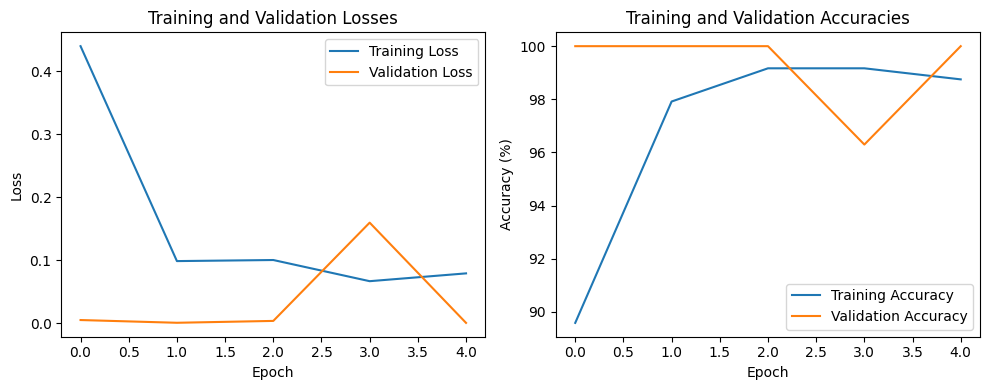

In [10]:
num_epochs = 5
for epoch in range(num_epochs):
    classification_network.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = classification_network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100. * correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    # Validation loop
    classification_network.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = classification_network(inputs)
            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()
    
    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100. * correct_val / total_val
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - Train Acc: {train_accuracy:.2f}% - Val Acc: {val_accuracy:.2f}%")

# Plot the training and validation losses
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

# Plot the training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracies')

plt.tight_layout()
plt.show()

In [11]:
# Set the model to evaluation mode
classification_network.eval()

# Lists to store predicted labels and true labels
predicted_labels = []
true_labels = []

# Testing loop
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = classification_network(inputs)
        _, predicted = outputs.max(1)
        predicted_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

# Convert the lists to PyTorch tensors
predicted_labels = torch.tensor(predicted_labels)
true_labels = torch.tensor(true_labels)

# Calculate accuracy
correct = (predicted_labels == true_labels).sum().item()
total = true_labels.size(0)
accuracy = (correct / total) * 100

print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 100.00%
